##  In this notebook we build different kinds of quantum trajectories. We will be primairly interested in the absorptive bistability (Jaynes Cummings model)

I store trajectory files as *.pkl files or *.mat files. This way I can easily load them into another notebook, or load the trajectories to matlab.

In [1]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [2]:
import os
directory_name = "/trajectory_data"
d = (os.getcwd() + directory_name)
try:
    os.stat(d)
except:
    os.mkdir(d)

In [3]:
####
####

### Current implemented regime is "absorptive_bistable"
### TODO: implement other regimes.

Regime = "absorptive_bistable"

####

### Which file formats to save trajectory data.
### Name of the file to save. The extension will be .mat for matlab and .pkl for pickle.

## matlab file.
save_mat = True
## pkl file (can be loaded in python) in the same format as above.
save_pkl = True
file_name = "." + directory_name + '/' + Regime

####
####

In [4]:
## Sometimes Macs will have an issue with Matplotlib, this seems to fix it.
## see http://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python

import matplotlib as mil
mil.use('TkAgg')

In [5]:
from qnet.algebra.operator_algebra import *
from qnet.algebra.circuit_algebra import *
import qnet.algebra.state_algebra as sa

import qutip

import sympy; sympy.init_printing(use_latex="mathjax")
from sympy import sqrt

import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import pickle

## Make operators

In [6]:
a = Destroy(1)
ad = a.dag()

sm = LocalSigma(2, 1,0)/sqrt(2)
sp = sm.dag()
sz = sp*sm - sm*sp 

j = Jminus(2)
jp = j.dag()
jz = Jz(2)

jx = (jp + j) / 2.
jy = (jp - j) / 2.

## Make SLH model

In [7]:
k,g0,g = symbols("kappa, g0,gamma", positive=True)
DD, TT = symbols("Delta, Theta", real=True)
W = symbols("Omega")

L = [sqrt(k)*a, 
     sqrt(g)*j]
H = -I*g0*(a*jp - ad * j) + DD*jz + TT*ad*a
S = identity_matrix(2)

slh = SLH(S, L, H).coherent_input(W,0)
slh

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(Omega, IdentityOperator), ScalarTimesOperator(sqrt(kappa), Destroy(LocalSpace('1', ''))))], [ScalarTimesOperator(sqrt(gamma), Jminus(LocalSpace('2', '')))]]), OperatorPlus(ScalarTimesOperator(Delta, Jz(LocalSpace('2', ''))), ScalarTimesOperator(-I*g0, OperatorPlus(ScalarTimesOperator(-1, OperatorTimes(Create(LocalSpace('1', '')), Jminus(LocalSpace('2', '')))), OperatorTimes(Destroy(LocalSpace('1', '')), Jplus(LocalSpace('2', ''))))), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(-Omega*sqrt(kappa), Create(LocalSpace('1', ''))), ScalarTimesOperator(sqrt(kappa)*conjugate(Omega), Destroy(LocalSpace('1', ''))))), ScalarTimesOperator(Theta, OperatorTimes(Create(LocalSpace('1', '')), Destroy(LocalSpace('1', ''))))))

## Compute parameters

In [8]:
## General parameters

params = {}

ntraj = params['Ntraj'] = 1
duration = params['duration'] = 200001
delta_t = params['delta_t'] = 2e-1
Nfock_a = params['Nfock_a'] = 50
Nfock_j = params['Nfock_j'] = 2

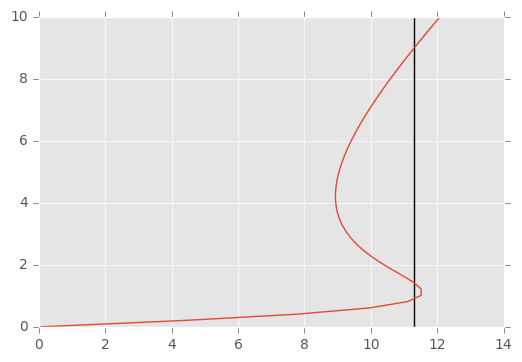

In [9]:
## Numerical parameters

a.space.dimension = Nfock_a
j.space.dimension = Nfock_j

# default are for absorptive bistability
def make_nparams(Cn=10.5, kn=.1, yn=11.3, DDn=0, TTn=0., J = 0.5):
    g0n = np.sqrt(2.*kn*Cn)
    Wn = yn*kn/np.sqrt(2)/g0n
    
    nparams = {
        W: Wn/np.sqrt(2*kn),
        k: 2*kn,
        g: 2./np.sqrt(2*J),
        g0: -g0n/np.sqrt(2*J),
        DD: DDn,
        TT: TTn,
    }
    xrs = np.linspace(0, 10)
    yrs = 2*Cn*xrs/(1+xrs**2) + xrs
    plt.plot(yrs, xrs)
    plt.vlines([yn], *plt.ylim())
    return nparams

if Regime == "absorptive_bistable":
    nparams = make_nparams()
else:
    raise ValueError("Unknown regime, or not implemented yet.")

Hq, Lqs = slh.substitute(nparams).HL_to_qutip()

In [27]:
## Put parameters in a single dictionary.

params.update({symbol.name:nparams[symbol] for symbol in nparams})

In [37]:
## Also add the numerical H and L matrices to params

params.update({'H_num': Hq.data, 'L_num': [l.data for l in Lqs]})

In [28]:
## Observables

obs = (a, j, jz, a*a, a.dag()*a, a*jp, jp, jx, jy)
obsq = [o.to_qutip(full_space=slh.space) for o in obs]

In [29]:
tlist = np.linspace(0, int(duration * delta_t), duration )
psi0 = qutip.tensor(qutip.basis(Nfock_a,0),qutip.basis(Nfock_j,0))
mcdata = qutip.mcsolve(
    Hq, psi0, tlist, Lqs, obsq, ntraj=ntraj, 
    options=qutip.Odeoptions(average_expect=False,
    store_states=True, seeds = ntraj*[333]
    ))

100.0%. Run time: 230.51s. Est. time left: 00:00:00:00
Total run time: 230.70s


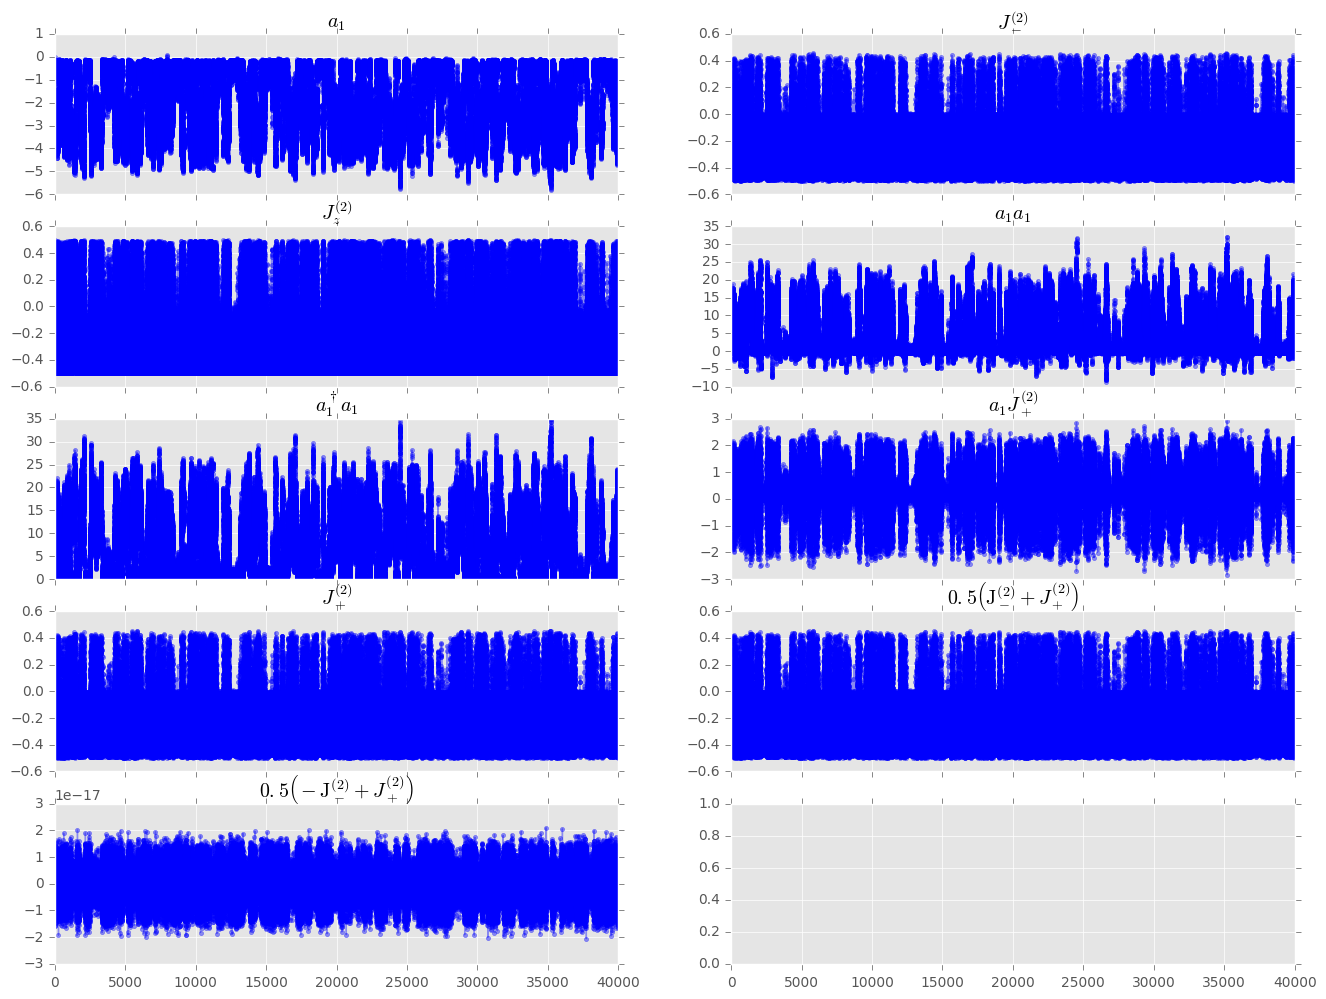

In [30]:
## Display observables

nobs = len(obsq)

nc = 2
nr = int(np.ceil(nobs/nc))

for jj in range(1): ## trajectory index
    f, axes = plt.subplots(nrows = nr, ncols=nc, sharex=True, figsize=(16,12))
    axesf = axes.ravel()
    for kk, obskk in enumerate(obs):  ## plot of each observable
        datakk = mcdata.expect[jj][kk].astype("complex128")
        axesf[kk].plot(tlist, np.real(datakk), "b.-", alpha=.4)
        if np.linalg.norm(np.imag(datakk)) > 1e-3:
            axesf[kk].plot(tlist, np.imag(datakk))
        axesf[kk].set_title(obskk._repr_latex_())
    plt.savefig("absorptive_bistability_trajectory_{:2d}.png".format(jj))

In [38]:
## save as matlab or pkl file

from mcdata2matfile_or_pkl import mcdata2matfile_or_pkl

if save_mat:
    mcdata2matfile_or_pkl(mcdata, file_name, obs, params, save_mat = True, save_pkl = False)    
if save_pkl:
    mcdata2matfile_or_pkl(mcdata, file_name, obs,  params, save_mat = False, save_pkl = True)

/Users/gil/Documents/repos/diffusion_maps/make_quantum_jump_trajectories/trajectory_data/absorptive_bistable.mat

/Users/gil/Documents/repos/diffusion_maps/make_quantum_jump_trajectories/trajectory_data/absorptive_bistable.pkl